In [27]:
## Reading necessary Python Libraries

import pandas as pd
import yfinance as yf
import datetime
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import joblib
import pickle


In [38]:
## Setting training period and prediction period

start_training = datetime.date(1990,1,1)
end_training = datetime.date(2021,12,31)
start_testing = datetime.date(2022,1,1)
end_testing = datetime.datetime.today()

ticker = 'MSFT'

In [39]:
## Getting the training data

df_training = yf.download(ticker, start = start_training, end=end_training, progress = False)
print(f"Downloaded {df_training.shape[0]} rows and {df_training.shape[1]} columns of {ticker} data")

Downloaded 8063 rows and 6 columns of MSFT data


In [40]:
## Formatting the time series data into Weekly Aggregated Stock Price

df_training = df_training.resample('W').agg({'Open':'first','High':'max','Low':'min','Close':'last','Adj Close':'last'})

In [41]:
## Model Selection
arima_fit = pm.auto_arima(df_training['Close'], error_action = 'ignore',suppress_warnings = True, stepwise = True, approximation= False, seasonal = True)

arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1670
Model:               SARIMAX(5, 2, 2)   Log Likelihood               -3786.522
Date:                Sat, 11 Feb 2023   AIC                           7589.043
Time:                        16:57:10   BIC                           7632.398
Sample:                    01-07-1990   HQIC                          7605.109
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4353      0.039     11.289      0.000       0.360       0.511
ar.L2         -0.0043      0.011     -0.386      0.699      -0.026       0.018
ar.L3          0.0693      0.009      7.315      0.000       0.051       0.088
ar.L4         -0.2075      0.011    -18.069      0.000      -0.230      -0.185
ar.L5         -0.0837      0.019     -4.465      0.000      -0.120      -0.047
ma.L1         -1.5512      0.036    -42.844      0.000      -1.622      -1.480
ma.L2          0.5620      0.036     15.725      0.000       0.492       0.632
sigma2         5.4718      0.056     97.107      0.000       5.361       5.582
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             36518.65
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               9.66   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
## Saving trained Auto Arima model as a serialized Pickle Object

with open(f'./Model_obj/arima_{ticker}.pkl', 'wb') as pkl:
    pickle.dump(arima_fit, pkl)

In [43]:
## Testing data

df_testing = yf.download(ticker, start = start_testing, end = end_testing, progress = False)
print(f"Downloaded {df_testing.shape[0]} rows and {df_testing.shape[1]} columns of {ticker} data")
df_testing.drop(columns = ["Open", "High","Adj Close","Low"],inplace = True)
df_testing.shape

Downloaded 279 rows and 6 columns of MSFT data


(279, 2)

In [44]:
## Setting Forecast Horizon
n_fcast1 = len(df_testing)
print(n_fcast1)

279


In [45]:
## Making Forecasts & retrieving confidence Intervals

arima_fcast = arima_fit.predict(n_periods = n_fcast1, return_conf_int = True, alpha = 0.05)
pred = pd.DataFrame(arima_fcast[0],columns = ['predictions']).set_index(df_testing.index)
conf_int = pd.DataFrame(arima_fcast[1],columns = ['lower_95','upper_95']).set_index(df_testing.index)

arima_fcast = pd.concat([pred,conf_int], axis=1)
arima_fcast.head()


,predictions,lower_95,upper_95
Date,,,
2022-01-03,339.228928,334.644184,343.813673
2022-01-04,343.769763,337.649933,349.889593
2022-01-05,346.967559,339.736189,354.198928
2022-01-06,348.052984,339.723195,356.382772
2022-01-07,350.049169,341.082349,359.015990


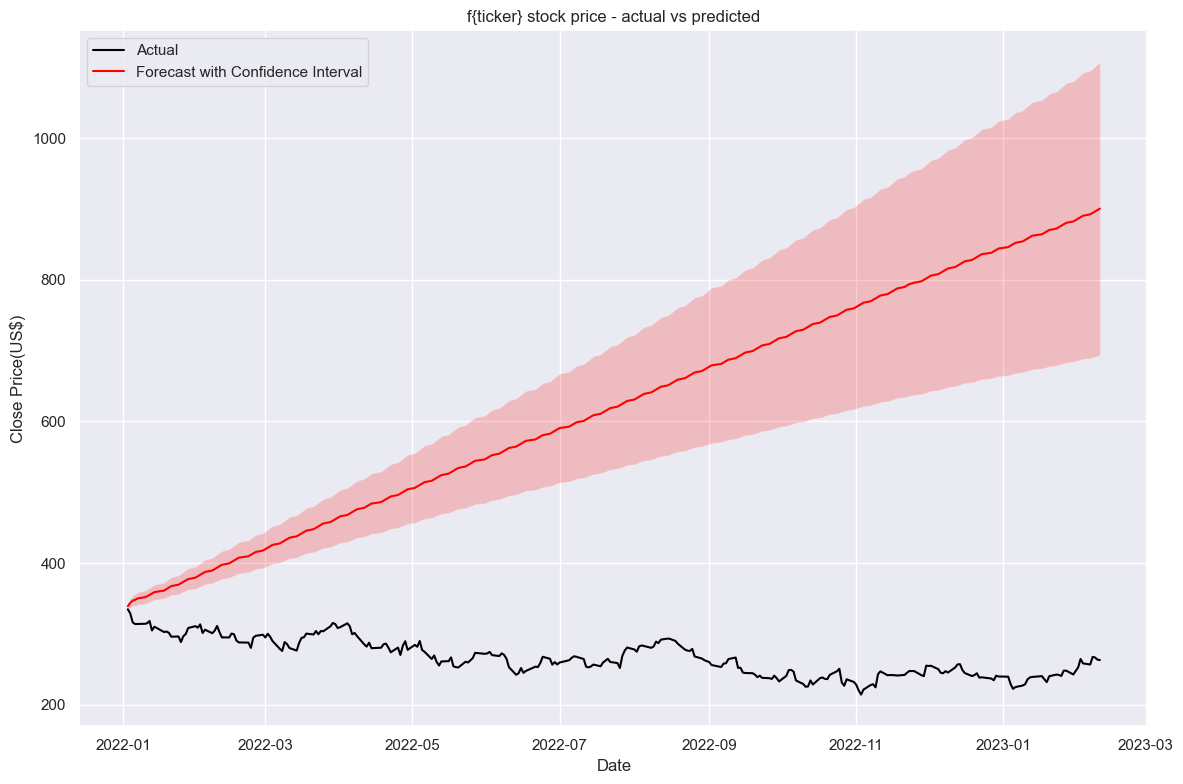

<Figure size 640x480 with 0 Axes>

In [46]:
## Plotting the Forecasts vs Actuals

fig, ax = plt.subplots(1,1, figsize = (12,8))

ax = sns.lineplot(data = df_testing['Close'],color = 'black',label = 'Actual')
ax.plot(arima_fcast.predictions, color = 'red', label = 'Forecast with Confidence Interval')

ax.fill_between(arima_fcast.index,arima_fcast.lower_95,arima_fcast.upper_95,alpha = 0.2,facecolor = 'red')
ax.set(title="f{ticker} stock price - actual vs predicted", xlabel = 'Date', ylabel = 'Close Price(US$)')
ax.legend(loc = 'upper left')

plt.tight_layout()
plt.show()
plt.savefig(f'./Plots/Predictions_{ticker}')